In [ ]:
# Si colocamos '!' delante de una linea esto indica que la línea se ejecutará como en una consola bash de la instancia de Compute Engine 
# sobre la que se ejecuta Datalab

# Con este comando vemos los paquetes Python instalados. Podemos apreciar que hay un gran número de paquetes preinstalados
!pip freeze

In [ ]:
# Con los dos símbolos '%%' y la palabra clave bash, se indica que toda la celda (y no solo la línea, como ocurría con '!')
# se ejecutará como si fueran comandos bash
# Por ejemplo, con estos comandos actualizaríamos los paquetes de python scikit-learn y tensorflow (en este notebook utilizaremos TensorFlow 1.1.0)

In [25]:
%%bash 
pip install sklearn --upgrade
pip install tensorflow==1.1.0
pip freeze

Requirement already up-to-date: sklearn in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: scikit-learn in /usr/local/lib/python2.7/dist-packages (from sklearn)
Requirement already up-to-date: six>=1.10.0 in /usr/local/lib/python2.7/dist-packages (from tensorflow)
Requirement already up-to-date: wheel in /usr/local/lib/python2.7/dist-packages (from tensorflow)
Requirement already up-to-date: mock>=2.0.0 in /usr/local/lib/python2.7/dist-packages (from tensorflow)
Requirement already up-to-date: funcsigs>=1; python_version < "3.3" in /usr/local/lib/python2.7/dist-packages (from mock>=2.0.0->tensorflow)
  Running setup.py bdist_wheel for markdown: started
  Running setup.py bdist_wheel for markdown: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/85/a7/08/33ee5cd488d0365d8bed79d1d4e5c28dd3fbfc7f6d0ad4bb09
  Running setup.py bdist_wheel for html5lib: started
  Running setup.py bdist_wheel for html5lib: finished with status 'done'
  Stored i

In [ ]:
# La documentación sobre el dataset público de los viajes en taxi en Chicago se encuentra en: https://cloud.google.com/bigquery/public-data/chicago-taxi
# Más información en: http://digital.cityofchicago.org/index.php/chicago-taxi-data-released

# Detalles del dataset (https://bigquery.cloud.google.com/dataset/bigquery-public-data:chicago_taxi_trips) a fecha de 11 de julio de 2017

# Tamaño tabla: 34.1 GB
# ID tabla: bigquery-public-data:chicago_taxi_trips.taxi_trips
# Número de filas: 99,761,096
# Número de columnas: 23


In [ ]:
"""
Ejemplo 1: llamada a la API de BQ 
Idea extraída de https://cloud.google.com/bigquery/docs/visualize-datalab
Realizaremos operaciones de preprocesamiento con Pandas y plotearemos un gráfico final con el número de viajes realizados en el mes de octubre
"""

In [104]:
import google.datalab.bigquery as bq

# Aprovechando que los tiempos de los viajes se guardan en intervalos de 15 minutos, 
# realizamos una query con el número de viajes en cada uno de esos intervalos

# La query se pasa como un string
query_string = 'SELECT trip_start_timestamp AS timestamp, COUNT(trip_start_timestamp) AS num_trips FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` GROUP BY timestamp ORDER BY timestamp ASC'
query = bq.Query(query_string)

# Pasamos a un dataframe de Pandas (la librería se importa automáticamente) el resultado de la query
df = query.execute(output_options=bq.QueryOutput.dataframe()).result()

# Vemos las 10 primeras filas del dataframe
df.head(10)

,timestamp,num_trips
0,2013-01-01 00:00:00,573
1,2013-01-01 00:15:00,1368
2,2013-01-01 00:30:00,1486
3,2013-01-01 00:45:00,1294
4,2013-01-01 01:00:00,1235
5,2013-01-01 01:15:00,1574
6,2013-01-01 01:30:00,1912
7,2013-01-01 01:45:00,1948
8,2013-01-01 02:00:00,1945
9,2013-01-01 02:15:00,1889


In [105]:
# Nos quedamos con los viajes realizados en octubre de 2016 utilizando Pandas

df['timestamp_year'] = df['timestamp'].dt.year
df['timestamp_month'] = df['timestamp'].dt.month
df['timestamp_hour'] = df['timestamp'].dt.hour
df = df.loc[df['timestamp_year'] == 2016]
df = df.loc[df['timestamp_month'] == 10]
df = df.drop('timestamp_year', axis=1)
df = df.drop('timestamp_month', axis=1)
df = df.drop('timestamp', axis=1)

# Reordenamos columnas (fuente: https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [106]:
# Volvemos a agregar datos por hora, dado que ahora los teniamos
# divididos en intervalos de 15 minutos (fuente: http://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)
df = df.groupby('timestamp_hour', as_index=False).agg({"num_trips": "sum"})

In [107]:
# Comprobamos que la tabla es correcta
df.head(10)

,timestamp_hour,num_trips
0,0,53279
1,1,42413
2,2,33453
3,3,24753
4,4,17214
5,5,14140
6,6,18545
7,7,35662
8,8,59722
9,9,70911


In [108]:
# Veamos una serie de estadísticas básicas sobre la tabla obtenida
df.describe()

,timestamp_hour,num_trips
count,24.000000,24.000000
mean,11.500000,62528.916667
std,7.071068,26674.884581
min,0.000000,14140.000000
25%,5.750000,40725.250000
50%,11.500000,69583.500000
75%,17.250000,80661.250000
max,23.000000,101489.000000


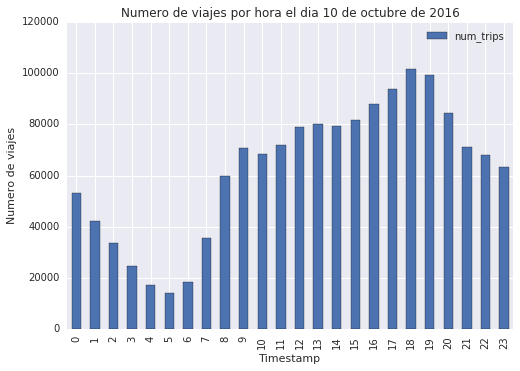

In [109]:
# Ploteamos el resultado de la query con un método de Pandas
# Podemos observar como se ha realizado un gran número de viajes entre las 4 y las 8 de la tarde
ax = df.plot(kind='bar',x='timestamp_hour',title='Numero de viajes por hora durante octubre de 2016')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Numero de viajes')

In [ ]:
"""
Ejemplo 2: llamada con celda 'mágica' a BQ
En este ejemplo intentaremos predecir el precio del viaje en taxi en función de las coordenadas donde se recoge y se deja al cliente, 
la duración y la distancia del viaje.
"""

In [1]:
# En este ejemplo volvemos a utilizar Pandas, así como Matplotlib para realizar ploteos y Numpy

from __future__ import division

import google.datalab.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Realizamos una llamada a BigQuery con lo que se denomina 'celda mágica'
# Obtenemos las columnas necesarias comprobando que no contengan valores nulos
# Tal y como se advierte en la memoria, trabajamos con una muestra de 300.000 datos. Esto se hace gracias a la claúsula LIMIT

In [2]:
%%bq query -n taxi_queries
SELECT trip_seconds, trip_miles, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_miles IS NOT NULL AND
      trip_seconds IS NOT NULL AND
      pickup_latitude IS NOT NULL AND 
      pickup_longitude IS NOT NULL AND
      dropoff_latitude IS NOT NULL AND
      dropoff_longitude IS NOT NULL AND  
      fare IS NOT NULL
LIMIT 300000

In [4]:
# Ejecutamos la query y la volcamos en un Pandas dataframe 
# Gracias a BigQuery, el tiempo de ejecución de la query es menor al minuto a pesar de ser una tabla de 100 millones de filas.
df = taxi_queries.execute(output_options=bq.QueryOutput.dataframe()).result()

In [114]:
df.head(20)

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare
0,720,3.21,41.920452,-87.679955,41.885281,-87.657233,9.85
1,120,0.60,41.920452,-87.679955,41.916005,-87.675095,4.45
2,900,0.20,41.920452,-87.679955,41.962179,-87.645379,12.45
3,2100,20.50,41.849247,-87.624135,41.979071,-87.903040,50.25
4,0,0.00,41.849247,-87.624135,41.849247,-87.624135,3.25
5,1380,5.20,41.849247,-87.624135,41.893216,-87.637844,15.25
6,1380,4.10,41.849247,-87.624135,41.893216,-87.637844,14.25
7,660,2.30,41.849247,-87.624135,41.877406,-87.621972,10.00
8,540,2.90,41.849247,-87.624135,41.890922,-87.618868,9.05
9,1560,3.90,41.849247,-87.624135,41.900221,-87.629105,14.65


In [5]:
# Normalización de columnas (normalizamos todo el dataset, por lo que si queremos utilizar más datos de esta tabla tendríamos que guardar la media y 
# la desviación típica, para así hacer entrenamientos con redes neuronales de forma correcta. En este caso hemos supuesto que esto no va a ocurrir)
cols_to_norm = ['pickup_latitude','pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

df.head()

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,fare
0,720,3.21,0.507829,-0.407624,-0.454571,-0.049205,9.85
1,120,0.60,0.507829,-0.407624,0.348448,-0.358583,4.45
2,900,0.20,0.507829,-0.407624,1.555261,0.156121,12.45
3,2100,20.50,-1.445325,0.481606,1.996765,-4.306708,50.25
4,0,0.00,-1.445325,0.481606,-1.396391,0.524069,3.25


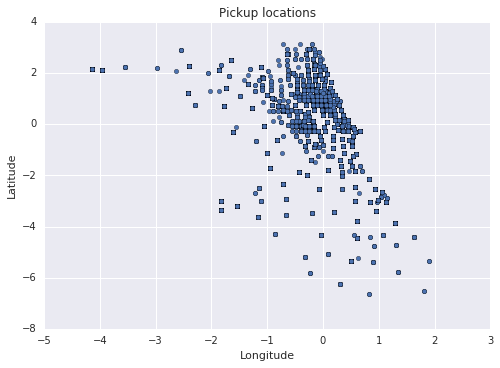

In [8]:
# Ploteamos en el plano los puntos de recogida
ax = df.plot(kind='scatter',x='pickup_longitude', y='pickup_latitude', title='Pickup locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

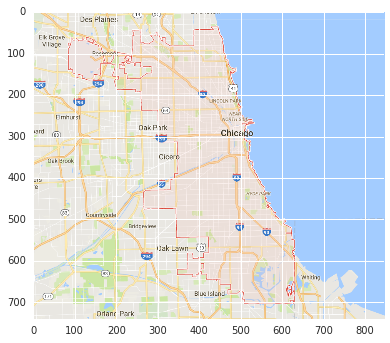

In [9]:
# En este mapa de la ciudad de Chicago vemos como los puntos de recogida y 'dropoff' se sitúan pegados a la línea costera

# Fuente: https://stackoverflow.com/questions/12116050/how-to-plot-remote-image-from-http-url
import urllib2
f = urllib2.urlopen("http://i.imgur.com/LMaPu6F.png")
a = plt.imread(f)
# Añadir format="jpg" para imágenes jpg
plt.imshow(a)
plt.show()


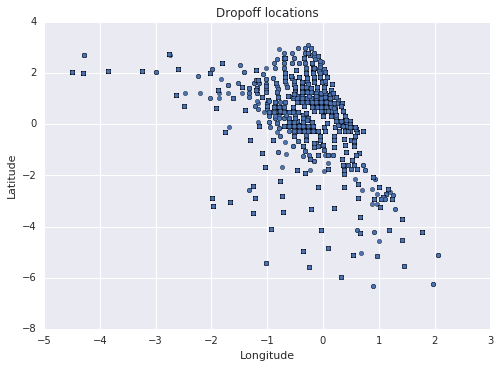

In [10]:
# Ploteamos en el plano los puntos donde se deja a los clientes (nótese como no hay gran diferencia con los puntos de recogida de clientes)

ax = df.plot(kind='scatter',x='dropoff_longitude', y='dropoff_latitude', title='Dropoff locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

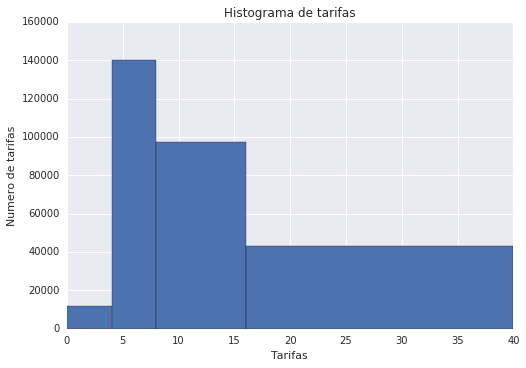

In [7]:
# Con este histograma podemos observar que hay un gran número de viajes cuya tarifa es entre 4 y 8 dólares
ax = df['fare'].hist(bins = [0, 4, 8, 16, 40])
ax.set_xlabel('Tarifas')
ax.set_ylabel('Numero de tarifas')
ax.set_title('Histograma de tarifas')

In [8]:
# Vamos a aplicar el algoritmo tsne de reducción de dimensionalidad (reduciendo de 6 a 2 las dimensiones, para así pintar los resultados en el plano)
# para comprobar 'cómo de distintos' son los viajes entre 4 y 8 dólares del resto
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Tomamos una muestra de 500 viajes en taxi
df_aux = df.sample(500).copy()

# Consideramos tarifas 'comunes' aquellas entre $4 y $8 y las indicamos con 1 en una columna. 0 en caso contrario
df_aux['normal_fare'] = df_aux['fare'].apply(lambda x: 1 if x >= 4 and x <= 8  else 0)
df_aux.drop('fare', axis=1, inplace=True)

# Nos quedamos con la columna de etiquetas que indican si la tarifa es 'común' o no
y = df_aux.ix[:,-1].values

df_aux.head()

,trip_seconds,trip_miles,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,normal_fare
206070,660,1.50,-0.622193,0.186674,-0.277069,0.441990,1
120866,540,0.17,1.257770,-0.469437,1.086057,-0.027814,1
194159,780,0.00,-1.168200,0.589571,-0.566615,0.374919,0
274985,420,0.00,-1.168200,0.589571,-0.838098,0.558058,1
287005,480,1.60,0.569129,0.077714,0.523067,0.084934,1


In [9]:
# La media de la columna que hemos creado nos permite saber el porcentaje de tarifas entre 4 y 8 dólares
df_aux['normal_fare'].describe()

count    500.000000
mean       0.508000
std        0.500437
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: normal_fare, dtype: float64

In [10]:
df_aux.drop('normal_fare', axis=1, inplace=True)

In [11]:
#Función para plotear tras aplicar tsne
def plot_data_2d(X, y, x_lims = None, y_lims = None):
  color_map = {0:'red', 1:'blue'}
  plt.figure()
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = X[y==cl,0], 
                y = X[y==cl,1], 
                c = color_map[idx], 
                label = cl)
  plt.xlabel('dimension 1 tras aplicar t-SNE')
  plt.ylabel('dimension 2 tras aplicar t-SNE')
  plt.legend(loc='upper left')
  plt.title('Algoritmo t-SNE ejecutado en el dataset de viajes de taxi en Chicago')
  if x_lims is not None and y_lims is not None:
    plt.xlim(x_lims)
    plt.ylim(y_lims)
  plt.show()
  

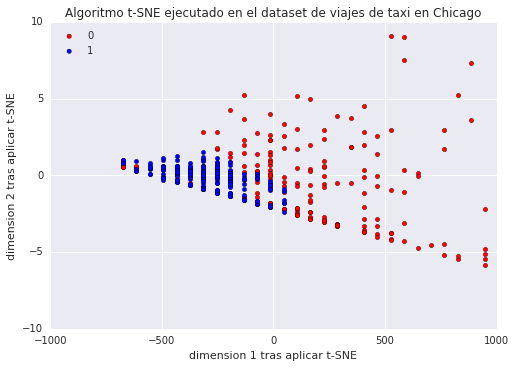

In [12]:
# Usamos PCA en este caso
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(df_aux)
X = pca.transform(df_aux)

x_lims = (X[:,0].mean()-1000,X[:,0].mean()+1000)
y_lims = (X[:,1].mean()-10,X[:,1].mean()+10)

plot_data_2d(X, y, x_lims, y_lims)

In [13]:
# Generamos el plot en dos dimensiones tras aplicar el alogritmo t-SNE del paquete de Scikit-learn
# Fuente: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


# Escalamos las variables para mejorar el tiempo de ejecución del algoritmo t-SNE
standard_scaler = StandardScaler()
df_std = standard_scaler.fit_transform(df_aux)

# Ejecutamos el algoritmo t-SNE (computacionalmente caro)
tsne = TSNE(n_components=2, random_state=0)
tsne_2d = tsne.fit_transform(df_std)

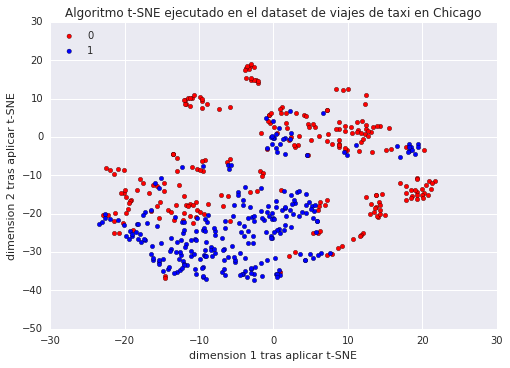

In [14]:
# Construimos un gráfico con los puntos obtenidos al aplicar t-SNE
# Con este resultado vemos que reduciendo las dimensiones a 2, no existe una separación realmente clara entre las tarifas 'comunes' y el resto
# por lo que necesitaríamos seguir realizando un análisis y limpiado de datos antes de aplicar el algoritmo t-SNE
plot_data_2d(tsne_2d, y)

In [ ]:
# Parece que a veces hay problemas al encontrar la función de split que se usa un par de celdas más adelante
# Para solucionarlo se requiere que el paquete Scikit-learn esté correctamente actualizado.
# En caso de seguir fallando reiniciar el kernel de Datlab por medio del botón (Reset Session)

In [16]:
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: scikit-learn in /usr/local/lib/python2.7/dist-packages (from sklearn)


In [18]:
# Pasamos ahora a la parte de entrenamiento con redes neuronales
# En primer lugar dividimos el dataset en datos de entrenamiento, validación y test gracias a otra función de Scikit-learn
#import sklearn
import sklearn.model_selection as ms

# Porcentajes de entrenamiento, validación y test (¡deben sumar 1 entre los tres!)
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VAL_SIZE = 0.1

# Pasamos el dataframe de Pandas a un array de Numpy
dataset = df.as_matrix()

# Realizamos la división en los tres conjuntos, obteniendo la matriz de variables por un lado y la columna con las tarifas en la otra
X_train, X_test, Y_train, Y_test = ms.train_test_split(dataset[:,:-1], dataset[:,-1], test_size=TEST_SIZE)

X_train, X_val, Y_train, Y_val = ms.train_test_split(X_train, Y_train, test_size=VAL_SIZE/TRAIN_SIZE)

In [21]:
# Nota: con Scikit-learn también se puede entrenar por medio de SVM y Regresiones logísticas. Para más info:
# SVM: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html y http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Regresión logística: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [35]:
# Con Keras no necesitamos importar el paquete de tensorflow como tal
#import tensorflow as tf
import sys


#import tensorflow.contrib.keras as keras

In [ ]:
!pip install keras

In [ ]:
# También se podría importar desde la librería de TensorFlow y nos ahorraría tiempo, pero parece que esto no es posible 
# issue en https://stackoverflow.com/questions/45032891/cannot-import-keras-from-tensorflow-contrib-package-in-datalab

#from tensorflow.contrib.keras import *
from tensorflow.contrib.keras.python.keras.regularizers import l1,l2
from tensorflow.contrib.keras.python.keras.models import Sequential, load_model
from tensorflow.contrib.keras.python.keras.layers import Dense, Dropout, Activation
from tensorflow.contrib.keras.python.keras.constraints import max_norm
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adam
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

In [50]:
import keras
from keras.regularizers import l1,l2
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.constraints import max_norm
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization

import os

# Eliminamos los warnings de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [ ]:
# Volvemos a limitar el dataset resultante de la query
LIMIT = 100000

# Limitamos los ejemplos de entrenamiento a viajes de menos de 20$

mask_train = Y_train < 20
mask_val = Y_val < 20
mask_test = Y_test < 20


X_train = X_train[mask_train]
Y_train = Y_train[mask_train]
X_val = X_val[mask_val]
Y_val = Y_val[mask_val]
X_test = X_test[mask_test]
Y_test = Y_test[mask_test]


TRAIN_LIMIT = int(LIMIT*TRAIN_SIZE)
VAL_LIMIT = int(LIMIT*VAL_SIZE)
TEST_LIMIT = int(LIMIT*TEST_SIZE)

x_train = X_train[:TRAIN_LIMIT]
y_train = Y_train[:TRAIN_LIMIT]
x_val = X_val[:VAL_LIMIT]
y_val = Y_val[:VAL_LIMIT]
x_test = X_test[:TEST_LIMIT]
y_test = Y_test[:TEST_LIMIT]

In [59]:
# Hyperparameters
batch_size = 500
epochs = 100
dropout_rate = 0.5

# Tenemos 6 neuronas de entrada (no contamos la última columna con las tarifas, pues es la que intentamos predecir)
input_dim = dataset.shape[1] - 1

model = Sequential()
model.add(Dense(4,input_shape=(input_dim,), kernel_initializer='he_normal'))

model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(3, kernel_initializer='he_normal'))

model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(3, kernel_initializer='he_normal'))

model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

model.summary()

#opt = Adam()
opt = RMSprop()

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=[keras.metrics.mean_absolute_error, keras.metrics.mean_absolute_percentage_error])

# Entrenamos el modelo (con verbose 0 apagamos el log y con 1 se muestra con barra de progreso)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_val, y_val))


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss (mse):', score[0])
print('Test mae:', score[1])
print('Test mape:', score[2])

y_pred = model.predict_proba(x_test, verbose = 0)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 4)                 28        
_________________________________________________________________
batch_normalization_5 (Batch (None, 4)                 16        
_________________________________________________________________
activation_5 (Activation)    (None, 4)                 0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 15        
_________________________________________________________________
batch_normalization_6 (Batch (None, 3)                 12        
_________________________________________________________________
activation_6 (Activation)    (None, 3)                 0         
__________

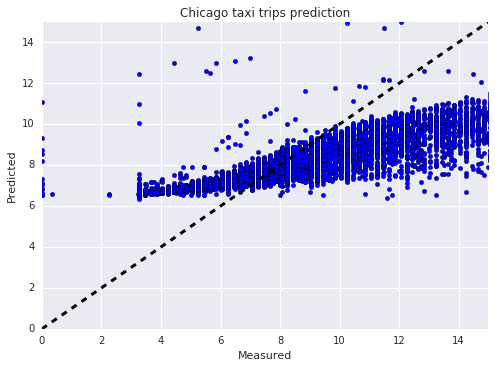

In [60]:
# Ploteamos en un gráfico las predicciones realizadas por nuestro modelo en el eje de ordenadas frente a los valores reales 
# de las tarifas en el eje de abcisas. Cuanto más alejados estén los puntos de la línea discontinua, las predicciones serán cada vez menos precisas 
import matplotlib.pyplot as plt

PLOT_LIM = 15
fig, ax = plt.subplots()
ax.scatter(y_test[:LIMIT], y_pred[:LIMIT] )
ax.plot([0, PLOT_LIM], [0, PLOT_LIM], 'k--', lw=3)
ax.set_xlim([0, PLOT_LIM])
ax.set_ylim([0, PLOT_LIM])
ax.set_title('Chicago taxi trips prediction')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [61]:
# Cogemos un viaje del conjunto de test y mostramos nuestra predicción
y_pred = model.predict_proba(x_test[49:50], verbose = 0)
y_pred

array([[ 7.54839993]], dtype=float32)

In [62]:
# Mostramos el valor real de ese viaje
y_test[49:50]

array([ 6.85])

In [63]:
# Enseñamos por pantalla en valor absoluto el error cometido en la predicción
abs(y_pred - y_test[49:50])

array([[ 0.69839993]])